<a href="https://colab.research.google.com/github/kidxcudi/ML_lab_model/blob/main/Toxic_speech_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import json
from datetime import datetime
import shutil

In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
# Keep only relevant columns
df = df[['comment_text', 'toxic']]
df.dropna(inplace=True)

In [ ]:
print("Data sample:")
print(df.head())
print("\nTarget distribution:")
print(df['toxic'].value_counts())

Data sample:
                                        comment_text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0

Target distribution:
toxic
0    144277
1     15294
Name: count, dtype: int64


In [ ]:
X = df[['comment_text']]

In [ ]:
y = df['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
# ColumnTransformer for text preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=50000, stop_words='english'), 'comment_text')
    ]
)

In [ ]:
# Full pipeline: preprocessing + Logistic Regression
pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

In [ ]:
# Fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=50000,
                                                                  stop_words='english'),
                                                  'comment_text')])),
                ('model', LogisticRegression(max_iter=2000))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.91      0.60      0.72      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915

Accuracy: 0.955726147579508


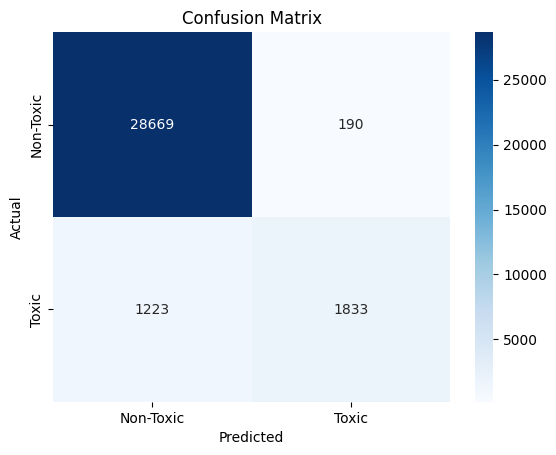

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Toxic","Toxic"],
            yticklabels=["Non-Toxic","Toxic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
BUNDLE_DIR = "toxic_model_bundle"
os.makedirs(BUNDLE_DIR, exist_ok=True)

In [ ]:
MODEL_PATH = os.path.join(BUNDLE_DIR, "model.joblib")
joblib.dump(pipeline, MODEL_PATH)

['toxic_model_bundle/model.joblib']

In [ ]:
schema = {
    "required_columns": ['comment_text'],
    "target": 'toxic'
}
with open(os.path.join(BUNDLE_DIR, "schema.json"), "w") as f:
    json.dump(schema, f, indent=2)

In [ ]:
metadata = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "model_type": "Pipeline(TfidfVectorizer + LogisticRegression)",
    "sklearn_version": sklearn.__version__,
    "metrics": {"accuracy": float(accuracy_score(y_test, y_pred))},
    "notes": "Binary toxic comment detection",
    "author": "Kid"
}
with open(os.path.join(BUNDLE_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

/tmp/ipython-input-4203797602.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


In [ ]:
example_inputs = X_test.head(10).copy()
golden_outputs = pipeline.predict(example_inputs)

example_inputs.to_json(os.path.join(BUNDLE_DIR, "example_inputs.json"), orient="records")
with open(os.path.join(BUNDLE_DIR, "golden_outputs.json"), "w") as f:
    json.dump({"predictions": golden_outputs.tolist()}, f, indent=2)

In [ ]:
pipeline_reloaded = joblib.load(MODEL_PATH)
golden_outputs_2 = pipeline_reloaded.predict(example_inputs)

if not all(golden_outputs == golden_outputs_2):
    raise RuntimeError("Reload validation FAILED: predictions differ after reload!")
print("\nReload validation PASSED: predictions match.")


Reload validation PASSED: predictions match.


In [ ]:
zip_path = shutil.make_archive("toxic_model_bundle", "zip", BUNDLE_DIR)
print("Model bundle zipped:", zip_path)

Model bundle zipped: /content/toxic_model_bundle.zip
